In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import wordnet, pos_tag, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [6]:
data = pd.read_csv('train.csv')
data = data.fillna("")

In [7]:
data.head()

,Id,Hotel_name,Review_Title,Review_Text,Rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0


In [8]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN


def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

stopwords = set(stopwords.words('english'))
good_words = open('positive-words.txt').read().split('\n')
bad_words = open('negative-words.txt').read().split('\n')

def text_preprocessing(raw_text, way_of_filter):
    raw_text = [i.lower() for i in raw_text]
    raw_text = [''.join([j for j in i if j not in '�,.!?/\-_+=*;:\"\'']) for i in raw_text]
    raw_text = [my_lemmatizer(i) for i in raw_text]
    if way_of_filter == "Только positive/negative слова":
        raw_text = [' '.join([j for j in i.split() if j in good_words or j in bad_words]) for i in raw_text]
    elif way_of_filter == "Без стоп-слов":
        raw_text = [' '.join([j for j in i.split() if j not in stopwords]) for i in raw_text]
    elif way_of_filter == "Без редких слов":
        words = ' '.join(raw_text).split()
        not_rare_words = []
        for i in set(words):
            if words.count(i) > 1:
                not_rare_words.append(i)
        raw_text = [' '.join([j for j in i.split() if j in not_rare_words]) for i in raw_text]
    return raw_text

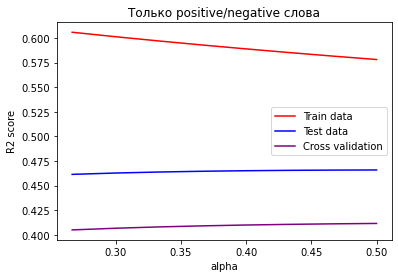

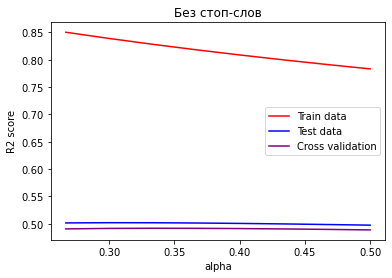

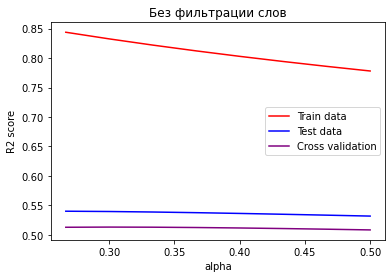

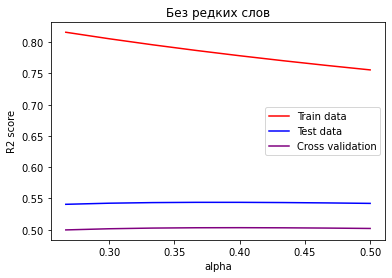

In [9]:
for way_of_filter in ["Только positive/negative слова", "Без стоп-слов", "Без фильтрации слов", "Без редких слов"]:
    preprocessed_data = text_preprocessing(data["Review_Text"], way_of_filter)
    idf_vectorizer = TfidfVectorizer().fit(preprocessed_data)
    preprocessed_data = idf_vectorizer.transform(preprocessed_data).todense()
    x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, data['Rating'], test_size=0.2)
    cross_history = []
    history_train = []
    history_test = []
    alphas = []
    for alpha in range(8, 16):
        alphas.append(alpha / 30)
        cross_history.append(cross_val_score(Ridge(alpha=alpha/16), preprocessed_data, data['Rating'], cv=5).mean())
        model = Ridge(alpha=alpha/16).fit(x_train, y_train)
        history_test.append(model.score(x_test, y_test))
        history_train.append(model.score(x_train, y_train))
    plt.plot(alphas, history_train, color='red', label='Train data')
    plt.plot(alphas, history_test, color='blue', label='Test data')
    plt.plot(alphas, cross_history, color='purple', label='Cross validation')
    plt.title(way_of_filter)
    plt.legend()
    plt.ylabel("R2 score")
    plt.xlabel("alpha")
    plt.show()

# R2 score модели, анализирующей комментарии:

In [10]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(l2_leaf_reg=0.5, silent=True, depth=8)
cross_val_score(model, np.array(preprocessed_data), np.array(data['Rating']), cv=5).mean()

0.5506843816826913

In [11]:
title_text = text_preprocessing(data['Review_Title'], "Без фильтрации слов")

In [12]:
idf_vectorizer = TfidfVectorizer().fit(title_text)
title_x = idf_vectorizer.transform(title_text).todense()

# R2 score модели, анализирующей заголовки:

In [13]:
model = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=8)

In [14]:
cross_val_score(model, np.array(title_x), np.array(data['Rating']), cv=5).mean()

0.4175832143604669

In [15]:
comment_text = text_preprocessing(data['Review_Text'], "Без редких слов")
idf_vectorizer = TfidfVectorizer().fit(comment_text)
comment_x = idf_vectorizer.transform(comment_text).todense()

In [16]:
size = len(title_text)
y = data['Rating'].values
v1, v2, r = np.array([]), np.array([]), np.array([])
score = 0
for j in range(5):
    x_1 = np.vstack([title_x[:size * j // 5], title_x[size * (j + 1) // 5:]])
    x_2 = np.vstack([comment_x[:size * j // 5], comment_x[size * (j + 1) // 5:]])
    y_1 = np.append(y[:size * j // 5], y[size * (j + 1) // 5:])
    model_1 = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=8).fit(np.array(x_1), np.array(y_1))
    model_2 = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=8).fit(np.array(x_2), np.array(y_1))
    pred_1 = model_1.predict(np.array(title_x[size * j // 5:size * (j + 1) // 5]))
    pred_2 = model_2.predict(np.array(comment_x[size * j // 5:size * (j + 1) // 5]))
    v1 = np.append(v1, pred_1)
    v2 = np.append(v2, pred_2)
    r = np.append(r, y[size * j // 5:size * (j + 1) // 5])

# R2 score ансамбля:

In [17]:
cross_val_score(LinearRegression(), np.array([v1, v2, v1 * v2]).transpose(), r, cv=5).mean()

0.5901801785804301

# Добавим в качестве фичей средний рейтинг отеля, количество отзывов о нём и их дисперсию:

In [18]:
hotel_names = {}
for i in zip(data["Hotel_name"], data['Rating']):
    if i[0] in hotel_names.keys():
        hotel_names[i[0]].append(i[1])
    else:
        hotel_names[i[0]] = [i[1]]

In [19]:
for i in hotel_names.keys():
    hotel_names[i] = np.array(hotel_names[i])
    hotel_names[i] = [hotel_names[i].mean(), hotel_names[i].var(), hotel_names[i].shape[0]]

In [20]:
means = np.array([hotel_names[i][0] for i in data['Hotel_name']])
varses = np.array([hotel_names[i][1] for i in data['Hotel_name']])
sizes = np.array([hotel_names[i][2] for i in data['Hotel_name']])

# R2 score итоговой модели:

In [21]:
model = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=2)

In [22]:
cross_val_score(model, np.array([v1, v2, v1 * v2, means, varses, sizes]).transpose(), r, cv=5).mean()

0.6627843416957223

In [23]:
final_title_model = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=8).fit(np.array(title_x), y)
final_comment_model = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=8).fit(np.array(comment_x), y)
final_merge_model = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=2).fit(np.array([v1, v2, v1 * v2, means, varses, sizes]).transpose(), r)

In [24]:
unknown_hotels_model = CatBoostRegressor(l2_leaf_reg=1.5, silent=True, depth=2).fit(np.array([v1, v2, v1 * v2]).transpose(), r)

In [25]:
check = pd.read_csv("test.csv")
check = check.fillna("")

In [26]:
check

,Id,Hotel_name,Review_Title,Review_Text
0,2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...
1,2352,Hotel Pandian,,Not so great. But it is still acceptable. Bit...
2,2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...
3,2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...
4,2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ..."
...,...,...,...,...
2347,4698,Lemon Tree Chennai,Average stay,"Compared to other lemon tree stay, this was bi..."
2348,4699,Oyo Rooms T Nagar Off Pondy Bazaar,location is not good. rude behavior. staff no ...,unpleasant stay. not easy task to reach. Morni...
2349,4700,VGP Golden Beach Resort,,Quality of service is too bad. We arrived 12.3...
2350,4701,The Park Chennai,Over rated and overpriced Hotel,I am not sure why someone wants to spend that ...


In [27]:
check_title = text_preprocessing(check['Review_Title'], "Без фильтрации слов")
idf_vectorizer = TfidfVectorizer().fit(check_title)
check_title = idf_vectorizer.transform(check_title).todense()

In [28]:
check_comment = text_preprocessing(check['Review_Text'], "Без редких слов")
idf_vectorizer = TfidfVectorizer().fit(check_comment)
check_comment = idf_vectorizer.transform(check_comment).todense()

In [29]:
answers = np.array([])

v1 = final_title_model.predict(np.array(check_title))
v2 = final_comment_model.predict(np.array(check_comment))
for i in range(len(check)):
    if check['Hotel_name'].iloc[i] in hotel_names.keys():
        answers = np.append(answers, final_merge_model.predict(np.array([v1[i], v2[i], v1[i] * v2[i], 
                                                                         hotel_names[check['Hotel_name'].iloc[i]][0],
                                                                         hotel_names[check['Hotel_name'].iloc[i]][1],
                                                                         hotel_names[check['Hotel_name'].iloc[i]][2]]).transpose()))
    else:
        answers = np.append(answers, unknown_hotels_model.predict(np.array([v1[i], v2[i], v1[i] * v2[i]]).transpose()))

In [30]:
answers

array([84.83251044, 72.67366412, 68.19250077, ..., 66.4722571 ,
       67.95104594, 66.37720419])

In [31]:
answers = pd.DataFrame({"ID": check["Id"], "Rating": answers})
answers.to_csv('submission.csv', index=False)